In [2]:
import numpy as np
import cantera as ct
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Experimental Data
Temp = np.arange(750,2000,50)
Feed = np.linspace(0.0001,0.01,50)

In [4]:
def run_simulation(Tx,Fx):
    # Separate gas and interface multipliers
    gas_mult = 5.08965517
    cat_mult = 89.55172414
    # import the model for gas-Fe interface and adjacent gas phase
    cat = ct.Interface('FeSiO2_NOMC.yaml','Fe_surf')
    gas = cat.adjacent['gas']

    # Set gas phase reaction multiplier
    gas.set_multiplier(gas_mult)
    # Set cat phase reaction multiplier
    cat.set_multiplier(cat_mult)

    T0 = Tx # K
    p0 = ct.one_atm # atm
    gas.TPX = T0, p0, "CH4: 0.9"
    cat.TP = T0, p0
    D = 0.004 # diameter of the tube [m]
    Ac = np.pi * D**2 / 4 # cross section of the tube [m2]
    w_cat = 0.84 # weight of catalyst [gcat]
    GHSV = Fx # m3/gcat/hr
    u0 = GHSV * w_cat /3600 / Ac # [m/s]

    # Set the Reactor conditions
    reactor = ct.FlowReactor(gas)
    reactor.area = Ac
    reactor.mass_flow_rate = 0.704672614990904 * u0 * Ac
    reactor.energy_enabled = False
    rsurf = ct.ReactorSurface(cat, reactor)
    net = ct.ReactorNet([reactor])
    soln = ct.SolutionArray(gas, extra=['x', 'surf_coverages'])

    # Integrate the reactor network
    while net.distance < 0.06:
        net.step()
        wdot = rsurf.kinetics.net_production_rates
        soln.append(TDY=reactor.thermo.TDY,
                    x=net.distance,
                    surf_coverages=rsurf.coverages
        )
    return (0.704672614990904 * u0 * Ac,soln('CH4').Y[-1][0],soln('H2').Y[-1][0],soln('C2H2').Y[-1][0],soln('C2H4').Y[-1][0],soln('C2H6').Y[-1][0],soln('C3H8').Y[-1][0] )


In [5]:
def Kinetic_Data(input):
    res = run_simulation(input[0],input[1])
    return res

In [6]:
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from itertools import product

x0 = Temp
x1 = Feed
xd = np.array(list(product(x0,x1)))
results = []

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(Kinetic_Data, x) for x in xd]

    for future in tqdm(futures, total=len(futures)):
        result = future.result()
        results.append(result)

print('처리 완료')

100%|██████████| 1250/1250 [05:13<00:00,  3.98it/s] 

처리 완료


In [7]:
res = np.array(results)
res.T

array([[1.64423610e-08, 4.96626414e-08, 8.28829219e-08, ...,
        1.57779554e-06, 1.61101582e-06, 1.64423610e-06],
       [9.99999828e-01, 9.99999950e-01, 9.99999971e-01, ...,
        1.22429080e-02, 1.22429072e-02, 1.22429069e-02],
       [1.08020269e-08, 3.14320765e-09, 1.84636268e-09, ...,
        1.85576345e-01, 1.85576345e-01, 1.85576345e-01],
       ...,
       [4.21614186e-11, 7.58647213e-12, 3.90095296e-12, ...,
        5.67243964e-03, 5.67243926e-03, 5.67243888e-03],
       [1.59013148e-07, 4.48514218e-08, 2.55160709e-08, ...,
        3.23436736e-06, 3.23436701e-06, 3.23436683e-06],
       [5.31015809e-13, 9.49448794e-14, 4.84996245e-14, ...,
        1.29748174e-09, 1.29748151e-09, 1.29748136e-09]])

In [8]:
df_temp = xd.T[0]
df_ghsv = xd.T[1]
df_F = res.T[0]
df_CH4 = res.T[1]
df_H2 = res.T[2]
df_C2H2 = res.T[3]
df_C2H4 = res.T[4]
df_C2H6 = res.T[5]
df_C3H8 = res.T[6]

df = {'Temp':df_temp, 'GHSV':df_ghsv, 'F':df_F}
df['WCH4'] = df_CH4
df['WH2'] = df_H2
df['WC2H2'] = df_C2H2
df['WC2H4'] = df_C2H4
df['WC2H6'] = df_C2H6
df['WC3H8'] = df_C3H8

results_df = pd.DataFrame(df)

display(results_df)



,Temp,GHSV,F,WCH4,WH2,WC2H2,WC2H4,WC2H6,WC3H8
0,750.0,0.000100,1.644236e-08,1.000000,1.080203e-08,2.197315e-18,4.216142e-11,1.590131e-07,5.310158e-13
1,750.0,0.000302,4.966264e-08,1.000000,3.143208e-09,1.189059e-19,7.586472e-12,4.485142e-08,9.494488e-14
2,750.0,0.000504,8.288292e-08,1.000000,1.846363e-09,3.569758e-20,3.900953e-12,2.551607e-08,4.849962e-14
3,750.0,0.000706,1.161032e-07,1.000000,1.389665e-09,1.868021e-20,2.752630e-12,1.870660e-08,3.403080e-14
4,750.0,0.000908,1.493235e-07,1.000000,1.000306e-09,8.697616e-21,1.835155e-12,1.290103e-08,2.247187e-14
...,...,...,...,...,...,...,...,...,...
1245,1950.0,0.009192,1.511355e-06,0.012243,1.855763e-01,7.958978e-01,5.672440e-03,3.234368e-06,1.297482e-09
1246,1950.0,0.009394,1.544575e-06,0.012243,1.855763e-01,7.958978e-01,5.672440e-03,3.234368e-06,1.297482e-09
1247,1950.0,0.009596,1.577796e-06,0.012243,1.855763e-01,7.958978e-01,5.672440e-03,3.234367e-06,1.297482e-09
1248,1950.0,0.009798,1.611016e-06,0.012243,1.855763e-01,7.958978e-01,5.672439e-03,3.234367e-06,1.297482e-09


(0.0, 1.0)

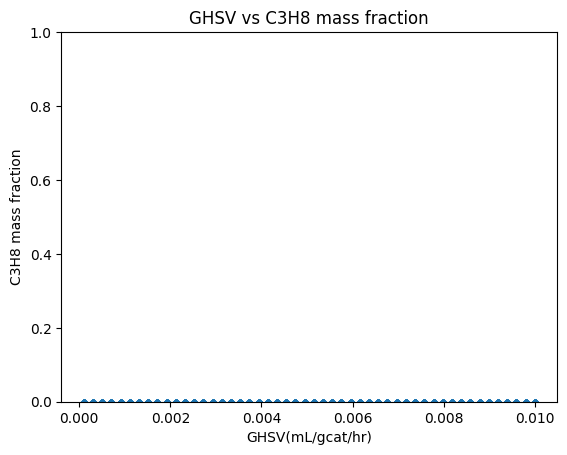

In [26]:
plt.scatter(df['GHSV'],df['WC3H8'],marker='.')
plt.title('GHSV vs C3H8 mass fraction')
plt.xlabel('GHSV(mL/gcat/hr)')
plt.ylabel('C3H8 mass fraction')
plt.ylim(0,1)

In [10]:
results_df.to_excel('kinetic data.xlsx')